In [5]:
import numpy as np
import cianparser
import time
import random
import csv
import json
import requests
import hashlib
import pandas as pd
import seaborn as sns
from datetime import datetime
import pandas as pd
from itertools import product
from concurrent.futures import ThreadPoolExecutor, as_completed
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from bs4 import BeautifulSoup



In [6]:
base = "base.csv"
df = pd.read_csv(base)

In [7]:
location_list = ['Москва', 'Москва и МО']
room = range(1, 5)

for a in range(1, 4):
    for loc in location_list:
        for i in room:
            for j in range(1, 54):
                    parser = cianparser.CianParser(location=loc)

                    data = parser.get_flats(
                        deal_type="sale", rooms=(i), 
                        with_saving_csv=False,
                        additional_settings={"start_page":j, "end_page":j}
                    )


                    if data:
                        with open(f'pars/pred/base_{a}_{loc}_{i}_{j}.csv', 'w', newline='', encoding="utf-8") as file:
                            writer = csv.DictWriter(file, fieldnames=data[0].keys())
                            writer.writeheader()

                            for dict_item in data:
                                writer.writerow(dict_item)

                    time.sleep(random.randint(5, 10))


                              Preparing to collect information from pages..
The page from which the collection of information begins: 
 https://cian.ru/cat.php?engine_version=2&p=1&with_neighbors=0&region=1&deal_type=sale&offer_type=flat&room1=1

 1 | 1 page with list: [=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>] 100% | Count of all parsed: 28. Progress ratio: 100 %. Average price: 215 478 667 rub

The collection of information from the pages with list of offers is completed
Total number of parsed offers: 28. 

                              Preparing to collect information from pages..
The page from which the collection of information begins: 
 https://cian.ru/cat.php?engine_version=2&p=2&with_neighbors=0&region=1&deal_type=sale&offer_type=flat&room1=1

 1 | 2 page with list: [=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>] 100% | Count of all parsed: 28. Progress ratio: 100 %. Average price: 84 669 014 rub

The collection of information from the pages with lis

KeyboardInterrupt: 

In [17]:
#конвертер
recuc = ['price']

for elm in recuc:
    df[recuc] = df[recuc].astype(int)

df.to_csv( base, index=False, encoding='utf-8-sig')

In [18]:
# - столбцы
total = df.drop(['url'], axis=1)
total.info()
total.to_csv( base, index=False, encoding='utf-8-sig')


KeyboardInterrupt



In [19]:
# - повторы
data = pd.read_csv(base)
data = data.drop_duplicates()
data.to_csv(base, index=False)

In [21]:
df = pd.read_csv(base)
df = df.dropna(subset=['floor','floors_count','rooms_count','total_meters','price'])
df.to_csv(base, index=False)
# чистка пустых

In [ ]:
def metro(row):
    if pd.isna(row['underground']): return False
    return True

def meters(row):
    return round(row['price']/row['total_meters'])

data['underground'] = data.apply(metro, axis=1)
data['price_per_meter'] = data.apply(meters, axis=1)
data.to_csv(base, index=False)

Анализ данных

In [7]:
a, b = df['price_per_meter'].quantile([0.25, 0.75])
IQR = b - a
lower_bound, upper_bound = a - 1.5 * IQR, b + 1.5 * IQR  
df_cleaned = df[(df['price_per_meter'] >= lower_bound) & (df['price_per_meter'] <= upper_bound)]
df_cleaned.to_csv( base, index=False, encoding='utf-8-sig')
#Stolen

Точность: 0.43


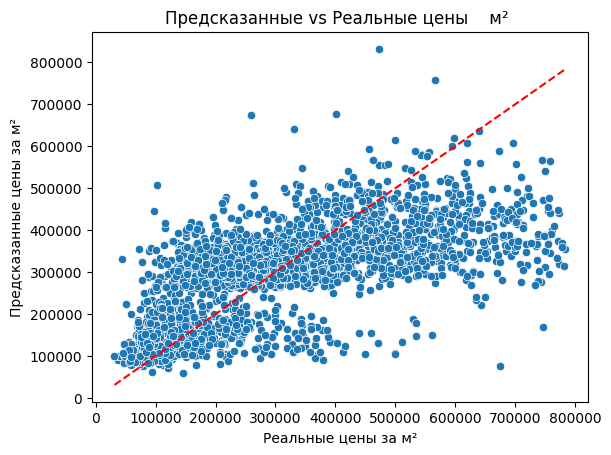

In [8]:
df = pd.read_csv(base)
X = df[['total_meters', 'rooms_count', 'underground', 'floor', 'floors_count']]
y = df['price_per_meter']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Оценка
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)


print(f'Точность: {r2:.2f}')

sns.scatterplot(x=y_test, y=y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.title('Предсказанные vs Реальные цены    м² ')
plt.xlabel('Реальные цены за м²')
plt.ylabel('Предсказанные цены за м²')
plt.show()

Точность: 0.71


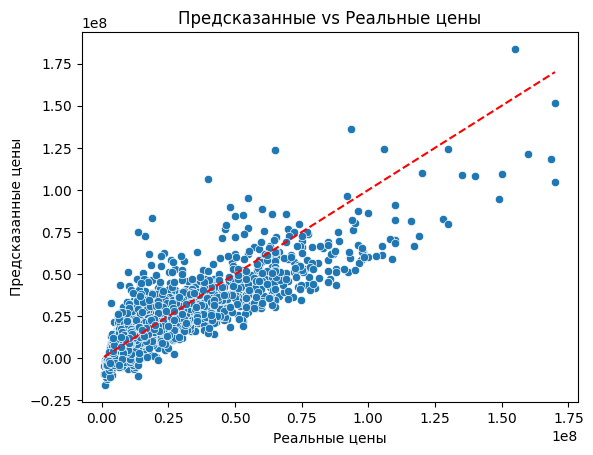

In [9]:
df = pd.read_csv(base)
X = df[['total_meters', 'rooms_count', 'underground', 'floor', 'floors_count']]
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Оценка
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)


print(f'Точность: {r2:.2f}')

sns.scatterplot(x=y_test, y=y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.title('Предсказанные vs Реальные цены')
plt.xlabel('Реальные цены')
plt.ylabel('Предсказанные цены')
plt.show()

Text(0.5, 1.0, 'проверка наличия Nan')

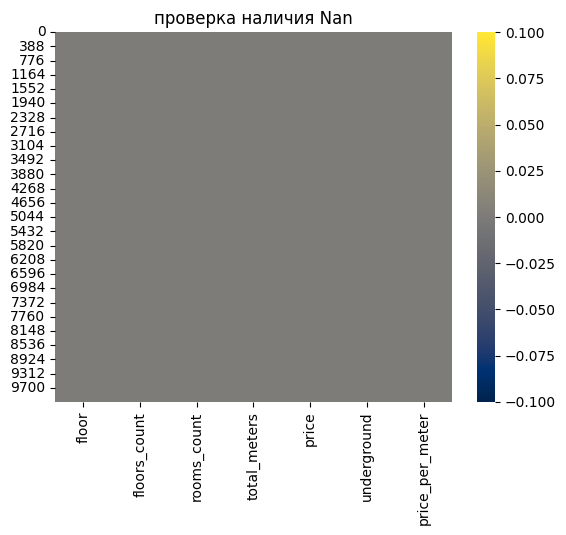

In [10]:
sns.heatmap(df.isnull(),cmap='cividis')
plt.title('проверка наличия Nan')

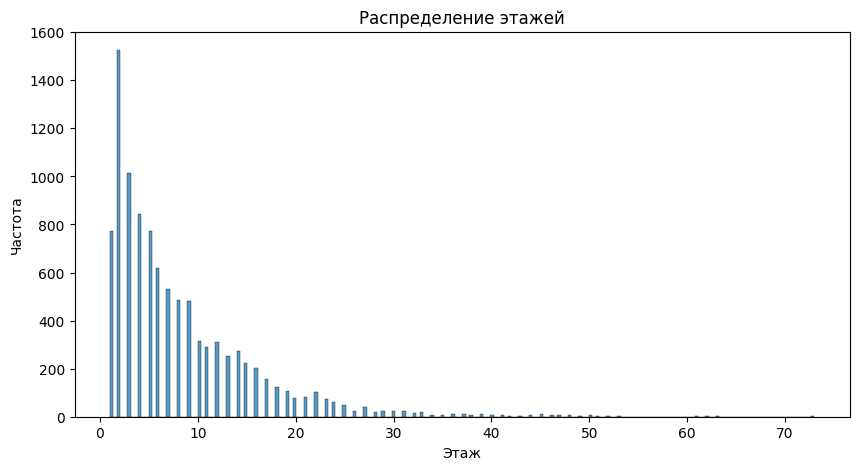

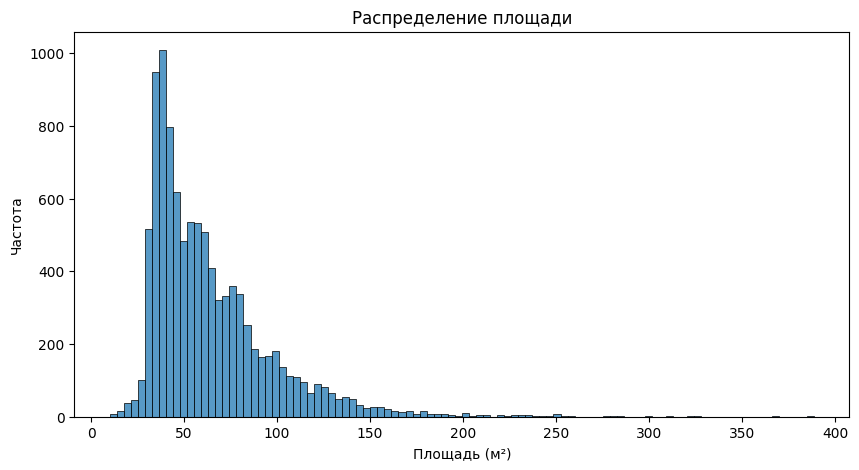

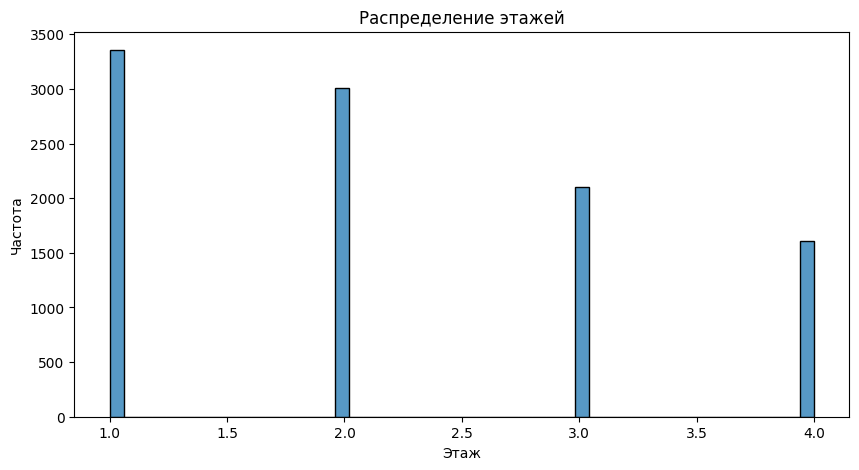

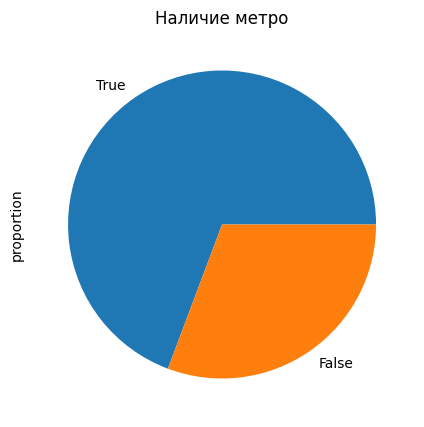

In [11]:
df = pd.read_csv(base)
df.describe()
plt.figure(figsize=(10, 5))
sns.histplot(df['floor'], bins=200, kde=False)
plt.title('Распределение этажей')
plt.xlabel('Этаж')
plt.ylabel('Частота')
plt.figure(figsize=(10, 5))
sns.histplot(df['total_meters'], bins=100, kde=False)
plt.title('Распределение площади')
plt.xlabel('Площадь (м²)')
plt.ylabel('Частота')
plt.figure(figsize=(10, 5))
sns.histplot(df['rooms_count'], bins=50, kde=False)
plt.title('Распределение этажей')
plt.xlabel('Этаж')
plt.ylabel('Частота')
plt.figure(figsize=(10, 5))
df['underground'].value_counts('underground').plot(kind = 'pie')
plt.title('Наличие метро')
plt.show()

Анализ влияния каждого из параметров на цену за метр

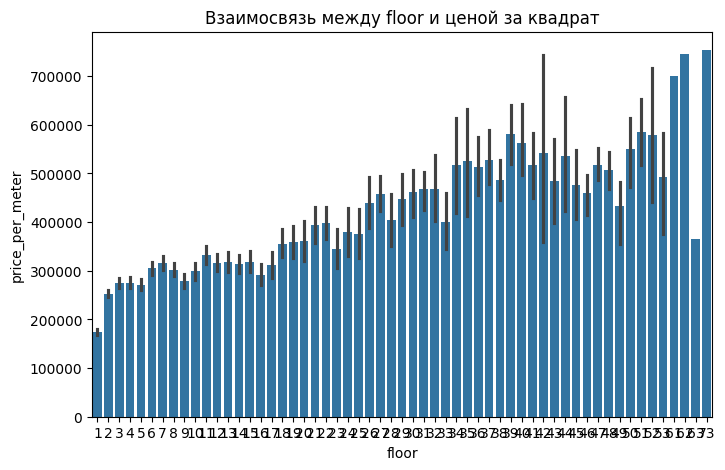

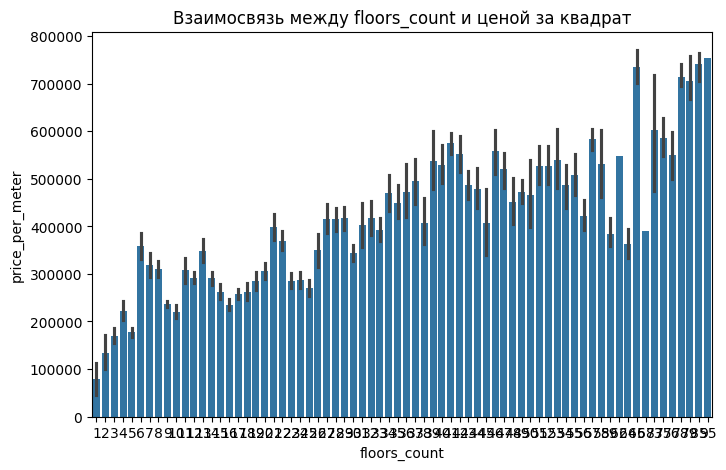

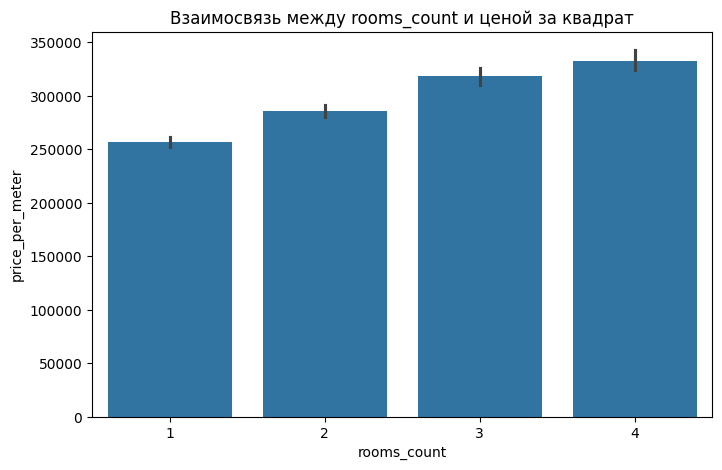

KeyboardInterrupt: 

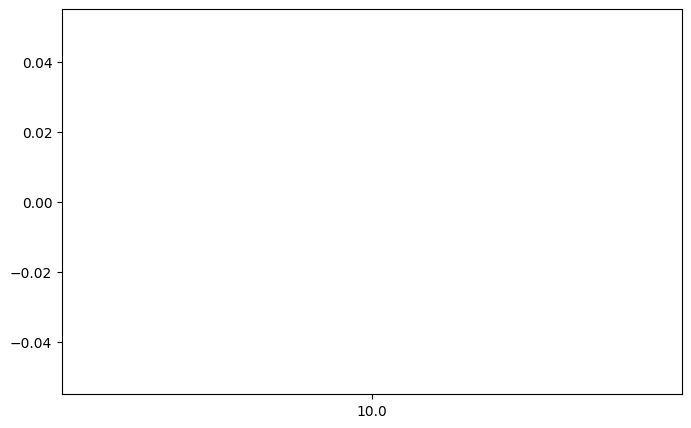

In [15]:
columns_to_plot = ['floor','floors_count','rooms_count','total_meters','underground']

for column in columns_to_plot:
    plt.figure(figsize=(8, 5))
    sns.barplot(data=df, x=column, y='price_per_meter')
    plt.title(f'Взаимосвязь между {column} и ценой за квадрат')
    plt.show()

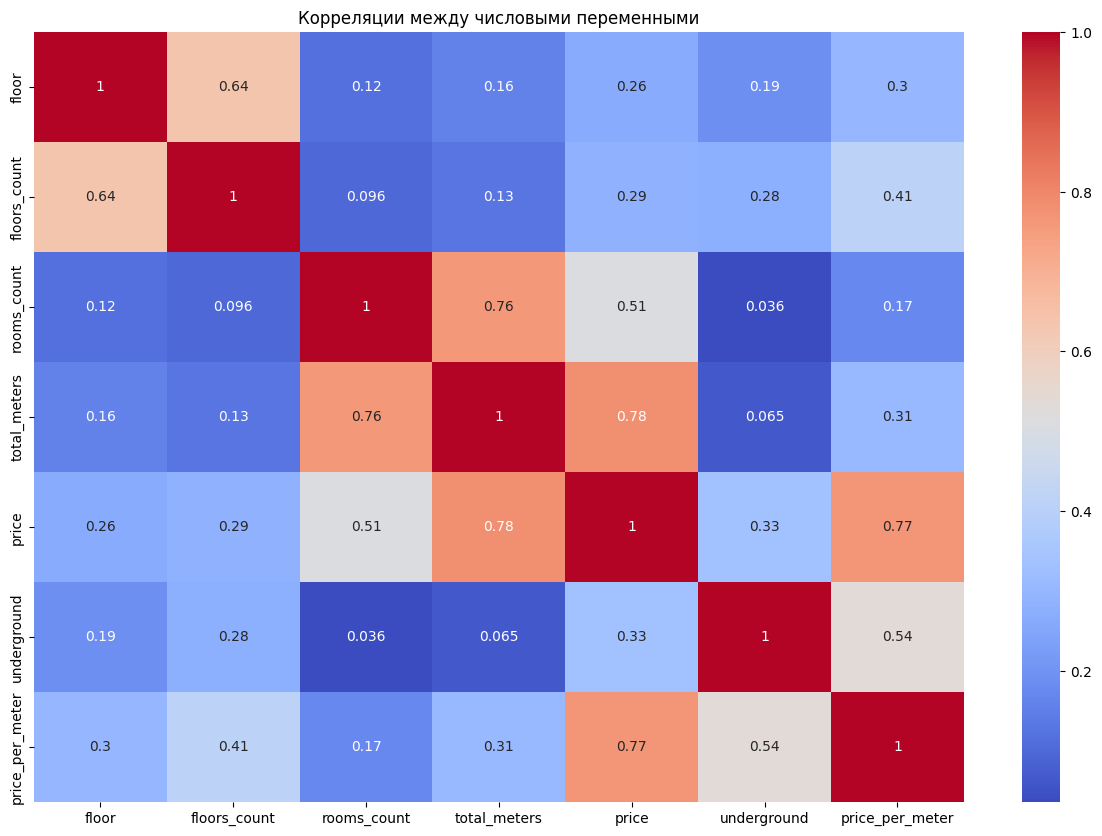

In [13]:
numeric_df = df.select_dtypes(include=['float64', 'int64', 'bool'])
plt.figure(figsize=(15, 10))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title('Корреляции между числовыми переменными')
plt.show()

In [152]:
df.info

total_meters
40.00     75
60.00     71
38.00     58
45.00     55
44.00     54
          ..
78.17      1
100.26     1
90.62      1
72.39      1
85.22      1
Name: count, Length: 2763, dtype: int64


<bound method DataFrame.info of        floor  floors_count  rooms_count  total_meters     price  underground  \
0         26            41            2         46.00  20950000         True   
1         11            12            1         33.50   8000000         True   
2          9            12            2         88.00  59350000         True   
3          4             7            1         31.10   6000000         True   
4          4            20            2         64.29  24166611         True   
...      ...           ...          ...           ...       ...          ...   
10534      3             6            3        116.00  21400000        False   
10535      9            10            3         92.30   7000000        False   
10536      9            25            3         64.54   8067500        False   
10537      6            17            3         76.70  17250597        False   
10538      4            11            3        127.30  59000000         True   

       